# RNN

In [192]:
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(0)

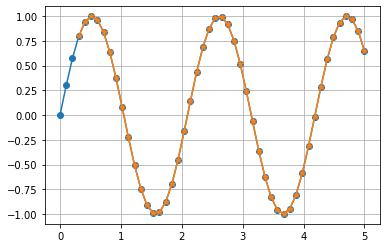

In [193]:
#Data
window = 3
n_data = 50 #Amount of Data
domain_x = 5 #Domain of Data
t = np.asarray(np.linspace(0, domain_x, n_data)) #Create X data
xt = np.asarray([np.sin(3*t[i]) + 0.0 * np.random.rand()  for i in range(n_data)]) #Create target data
x_w = np.asarray([xt[i:i+window] for i in range(len(xt)-window)])
y = np.asarray(xt[window:])
plt.plot(t,xt,label='True data', marker='o')
plt.plot(t[window:],y,marker='*')
plt.grid()
plt.show()

In [194]:
def MSE(y_true,y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [195]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [196]:
def d_sig(x):
    return sigmoid(x)*(1-sigmoid(x))

In [197]:
#LSTM cell
class LSTM:
    
    def __init__(self, input_size, h_size):
        self.input_size = input_size
        self.h_size = h_size
        self.Wf = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Forget weights
        self.Wi = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Input weights
        self.Wo = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Output weights
        self.Wc = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Cell Input weights
        self.bf = np.random.randn(h_size) #Forget bias
        self.bi = np.random.randn(h_size) #Input bias
        self.bo = np.random.randn(h_size) #Output bias
        self.bc = np.random.randn(h_size) #Cell Input bias
        self.c_state = np.random.uniform(-1, 1, (h_size,1)) #Cell state
        self.h_state = np.random.uniform(-1, 1, (h_size,1)) #Hidden state
        
        self.concat = np.zeros((input_size + h_size)) #Concatenated Values
        
        self.f = 0 #forget gate
        self.i = 0 #input gate
        self.o = 0 #output gate
        self.c_hat = 0 #candidate cell state
        
        self.Wf_g = np.zeros((h_size, input_size + h_size)) #Forget gradient
        self.Wi_g = np.zeros((h_size, input_size + h_size)) #Input Gradient
        self.Wo_g = np.zeros((h_size, input_size + h_size)) #Output Gradient
        self.Wc_g = np.zeros((h_size, input_size + h_size)) #Cell Gradient
        self.bf_g = np.zeros(h_size) #Forget bias gradient
        self.bi_g = np.zeros(h_size) #Input bias gradient
        self.bo_g = np.zeros(h_size) #Output bias gradient
        self.bc_g = np.zeros(h_size) #Cell bias Gradient
        self.c_state_g = np.zeros(h_size) #Cell State Gradient
        self.h_state_g = np.zeros(h_size) #Hidden State Gradient
        
    def forward(self, x, h_prev, c_prev):
        self.concat = np.hstack((h_prev, x)) #Concatenated hidden state and input
        print(self.Wf.shape,self.concat.shape,self.bf.shape)
        self.f = sigmoid(np.dot(self.Wf, self.concat) + self.bf) #Forget cell
        self.i = sigmoid(np.dot(self.Wi, self.concat) + self.bi) #Input cell
        self.o = sigmoid(np.dot(self.Wo, self.concat) + self.bo) #Output cell
        self.c_hat = np.tanh(np.dot(self.Wc, self.concat) + self.bc) #Cell state

        self.c_state = self.f * c_prev + self.i * self.c_hat #New Cell State
        self.h_state = self.o * np.tanh(self.c_state) #New Hidden State

        return self.h_state, self.c_state
    
    def backward(self, x, d_h_state, d_c_state):
        self.h_state_g = d_h_state 
        d_o = d_h_state * np.tanh(self.c_state) * d_sig(np.dot(self.Wo, self.concat) + self.bo)
        d_c = (d_h_state * self.o * (1 - np.tanh(self.c_state)**2)) + d_c_state
        d_i = d_c * self.c_hat * d_sig(np.dot(self.Wi, self.concat) + self.bi)
        d_f = d_c * self.c_state * d_sig(np.dot(self.Wf, self.concat) + self.bf)
        d_c_hat = d_c * self.i * (1 - self.c_hat**2)
        
        self.Wf_g += np.outer(d_f, self.concat)
        self.Wi_g += np.outer(d_i, self.concat)
        self.Wc_g += np.outer(d_c_hat, self.concat)
        self.Wo_g += np.outer(d_o, self.concat)
        
        self.bf_g += d_f
        self.bi_g += d_i
        self.bc_g += d_c_hat
        self.bo_g += d_o
        
        dconcat = np.dot(self.Wf.T, d_f) + np.dot(self.Wi.T, d_i) + np.dot(self.Wc.T, d_c_hat) + np.dot(self.Wo.T, d_o)
        
        dx = dconcat[:self.input_size] 
        dh_prev = dconcat[self.input_size:]

        return dx, dh_prev, d_c * self.f
    
    def update(self, lr=0.0001):
        self.Wf -= lr * self.Wf_g
        self.Wi -= lr * self.Wi_g
        self.Wc -= lr * self.Wc_g
        self.Wo -= lr * self.Wo_g
        
        self.bf -= lr * self.bf_g
        self.bi -= lr * self.bi_g
        self.bc -= lr * self.bc_g
        self.bo -= lr * self.bo_g
        
        # Reset gradients after updating
        self.Wf_g.fill(0)
        self.Wi_g.fill(0)
        self.Wc_g.fill(0)
        self.Wo_g.fill(0)
        
        self.bf_g.fill(0)
        self.bi_g.fill(0)
        self.bc_g.fill(0)
        self.bo_g.fill(0)


In [198]:
#Forward Pass
L_Cell = LSTM(3,5)
H,C = L_Cell.forward(x_w[0],[0,0,0,0,0],[0])
print(H,C)

(5, 8) (8,) (5,)
[ 0.36855265 -0.03880076  0.07989474  0.21676048  0.45472432] [ 0.89476102 -0.07072982  0.18322363  0.30611872  0.54618087]


In [199]:
dX, dH, dC = L_Cell.backward(x_w[0],H,C)
print(dX,dH,dC)

[0.6870477  0.59905608 0.54499085] [0.43328658 0.54387603 0.47276619 0.67316505 0.66452594] [ 0.6355627  -0.0790122   0.14045619  0.3416808   0.58864505]


(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5

(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5

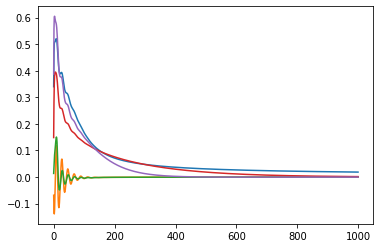

In [205]:
Hs = []
H = [0,0,0,0,0]
C = [0,0,0,0,0]
for i in range(1000):
    H,C = L_Cell.forward(x_w[0],H,C)
    dX, dH, dC = L_Cell.backward(x_w[0],H,C)
    L_Cell.update(0.1)
    Hs.append(H)
Hs = np.asarray(Hs)
plt.plot(Hs)

In [206]:
class RNN:
    
    def __init__(self, input_size, h_size, out_size, lr=0.001):
        self.input_size = input_size
        self.h_size = h_size
        self.out_size = out_size
        
        self.LSTM_Cells = []
        self.H = [np.zeros(h_size)]
        self.C = [np.zeros(h_size)]
        
        self.Wy = np.random.rand(out_size, h_size)
        self.by = np.zeros(out_size)
        
        self.dWy = np.zeros((out_size,h_size))
        self.dby = np.zeros(out_size)
        
        self.lr = lr
        
        self.Losses = []
        
    def forward(self, x):
        for t in range(x.shape[0]):
            self.LSTM_Cells.append(LSTM(self.input_size,self.h_size))
            h,c = self.LSTM_Cells[t].forward(x[t],self.H[t],self.C[t])
            self.H.append(h)
            self.C.append(c)
        y = self.Wy.dot(h) + self.by
        return y
    
    def backward(self, x, dy):
        self.dWy = dy * self.H[-1].T
        self.dby = dy
        
        dh = self.Wy.T * dy
        dc = np.zeros_like(self.C[-1])
        for t in reversed(range(x.shape[0])):
            h_prev = self.H[t-1] if t > 0 else np.zeros_like(self.H[0])
            c_prev = self.C[t-1] if t > 0 else np.zeros_like(self.C[0])
            
            dx, dh, dc = self.LSTM_Cells[t].backward(x[t], h_prev, c_prev)
    
    def train(self, x, yt, epochs = 100):
        for epoch in range(epochs):
            print("Epoch: "+str(epoch))
            R = np.random.randint(0,x.shape[0])
            epoch_loss = 0
            out = self.forward(x[R])
            loss = MSE(out,yt[R])
            epoch_loss += loss

            dy = out - yt[R]
            self.backward(x[R],dy)
            
            self.Wy -= self.dWy.dot(self.lr)
            self.by -= self.lr * self.dby
                
            for l in self.LSTM_Cells:
                l.update(self.lr)
                
            self.Losses.append(epoch_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(x)}')

In [207]:
R = RNN(window,5,1)
R.forward(x_w)

(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)
(5, 8) (8,) (5,)


array([2.83308866])

In [208]:
R.backward(x_w,1)
R.dWy, R.dby

(array([0.97652702, 0.96623291, 0.81697503, 0.978969  , 0.93157112]), 1)

In [209]:
R = RNN(window,5,1)
R.train(x_w,y)

Epoch: 0
(5, 8) (6,) (5,)


ValueError: shapes (5,8) and (6,) not aligned: 8 (dim 1) != 6 (dim 0)

In [ ]:
import numpy as np

# Dummy data generation for testing
def generate_data(seq_length, num_sequences, input_size):
    X = np.random.rand(num_sequences, seq_length, input_size)
    y = np.random.rand(num_sequences, input_size)
    return X, y

# Loss function (Mean Squared Error)
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Training the LSTM
def train_lstm(lstm, X, y, epochs=100, lr=0.001):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(X)):
            h_prev = np.zeros(lstm.h_size)
            c_prev = np.zeros(lstm.h_size)
            for t in range(X.shape[1]):
                h_prev, c_prev = lstm.forward(X[i, t], h_prev, c_prev)
            loss = mse_loss(y[i], h_prev)
            total_loss += loss
            
            # Backpropagation through time
            d_h_state = h_prev - y[i]
            d_c_state = np.zeros(lstm.h_size)
            for t in reversed(range(X.shape[1])):
                dx, dh_prev, dc_prev = lstm.backward(X[i, t], d_h_state, d_c_state)
                d_h_state = dh_prev
                d_c_state = dc_prev
            
            # Update weights
            lstm.update(lr)
        
        avg_loss = total_loss / len(X)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}')
    
    return losses

# Initializing the LSTM cell
input_size = 10
h_size = 10
seq_length = 5
num_sequences = 100

lstm = LSTM(input_size, h_size)

# Generating data
X, y = generate_data(seq_length, num_sequences, input_size)

# Training the LSTM
losses = train_lstm(lstm, X, y, epochs=50, lr=0.01)

# Plotting the loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()
